# check history loss

validation from augmented data

In [1]:
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'

%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import tensorflow as tf
import numpy as np
import datetime

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import Adam

#import data
#import importlib.util
#spec = importlib.util.spec_from_file_location("data", "../mnist/data.py")
#data = importlib.util.module_from_spec(spec)
#spec.loader.exec_module(data)



Using TensorFlow backend.


In [2]:
#import data
! cp ../mnist/data.py data_mnist.py
! cp ../digit_recognizer/data.py data_digit_recognizer.py
import data_mnist
import data_digit_recognizer

In [3]:
DATA_ROOT = 'contest'
DATA_ROOT = 'dry_run'

SUBMISSION_ROOT = os.path.join(DATA_ROOT, 'submissions')
if not os.path.isdir(SUBMISSION_ROOT):
    os.mkdir(SUBMISSION_ROOT)

IMAGE_COLS = 28
IMAGE_ROWS = 28

ORIGINAL_TRAIN_SIZE = 10000
ORIGINAL_TEST_SIZE = 50000


In [4]:
%%time
# Read contest Data 

original_train_id, original_train_label = data_digit_recognizer.read_mnist_id_for_contest(os.path.join(DATA_ROOT, 'train.csv'))
original_train_id, original_train_image = data_digit_recognizer.read_mnist_for_contest(
    os.path.join(DATA_ROOT, 'train'), original_train_id)

original_test_id, original_test_image = data_digit_recognizer.read_mnist_for_contest(os.path.join(DATA_ROOT, 'test'))

CPU times: user 780 ms, sys: 235 ms, total: 1.01 s
Wall time: 1.02 s


original_train_id: (10000,)
original_train_label: (10000,)
original_train_image: (10000, 784)
original_test_id: (50000,)
original_test_image (50000, 784)


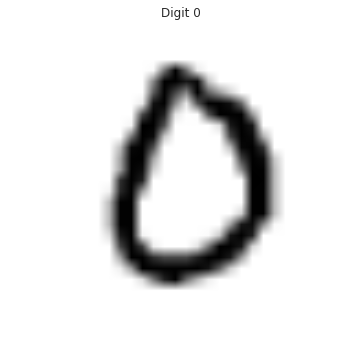

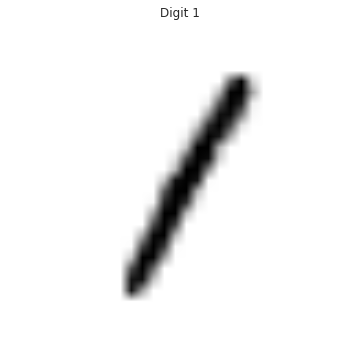

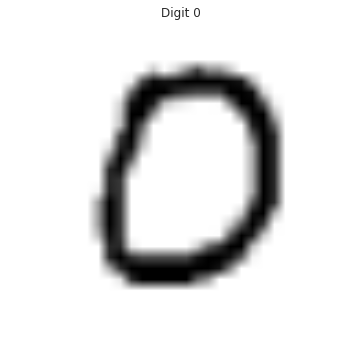

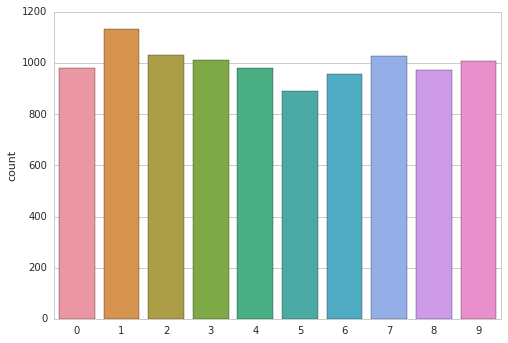


Max: 1135 Label 1
Min: 892 Label 5
Max/Min = 1.27



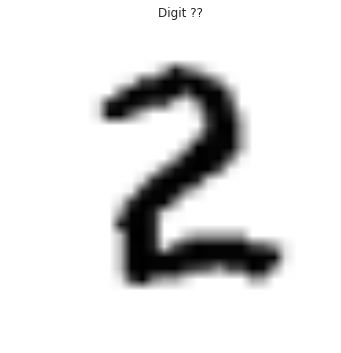

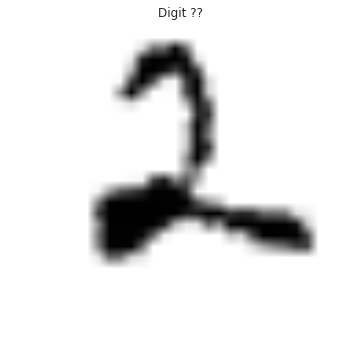

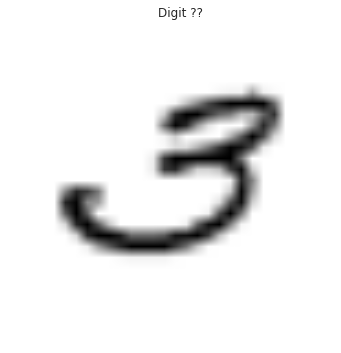

In [5]:
# check data

print('original_train_id:', original_train_id.shape)
print('original_train_label:', original_train_label.shape)
print('original_train_image:', original_train_image.shape)

assert(original_train_id.shape == (ORIGINAL_TRAIN_SIZE,))
assert(original_train_label.shape == (ORIGINAL_TRAIN_SIZE,))
assert(original_train_image.shape == (ORIGINAL_TRAIN_SIZE, IMAGE_COLS*IMAGE_ROWS))

print('original_test_id:', original_test_id.shape)
print('original_test_image', original_test_image.shape)

assert(original_test_id.shape == (ORIGINAL_TEST_SIZE,))
assert(original_test_image.shape == (ORIGINAL_TEST_SIZE, IMAGE_COLS*IMAGE_ROWS))

for i in range(10, 10+3):
    data_digit_recognizer.show_digit(original_train_image[i], original_train_label[i])
    
data_digit_recognizer.analyze_labels(original_train_label)

for i in range(10, 10+3):
    data_digit_recognizer.show_digit(original_test_image[i])

In [5]:
%%time
# Read dry_run test data as validation
DRY_RUN_DATA_ROOT = '../mnist/dry_run/'
! ls ../mnist/dry_run

original_valid_id, original_valid_label = data_mnist.read_contest_ids(os.path.join(DRY_RUN_DATA_ROOT, 'test.csv'))
original_valid_id, original_valid_image = data_mnist.read_contest_images(os.path.join(DRY_RUN_DATA_ROOT, 'test'), original_valid_id)


original_test_id.npy	  test	     train_image_50.npy
original_test_image.npy   test.csv   train_label_50.npy
original_train_image.npy  train
original_train_label.npy  train.csv
CPU times: user 923 ms, sys: 226 ms, total: 1.15 s
Wall time: 1.26 s


original_valid_id: (50000,)
original_valid_image: (50000, 784)
original_valid_label: (50000,)


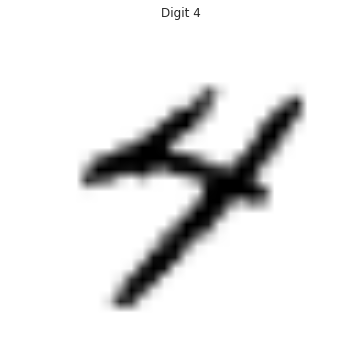

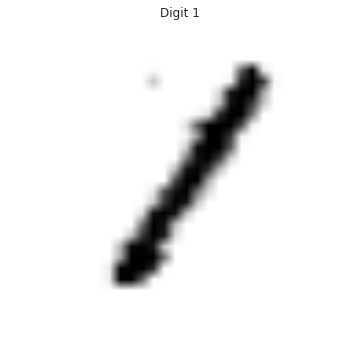

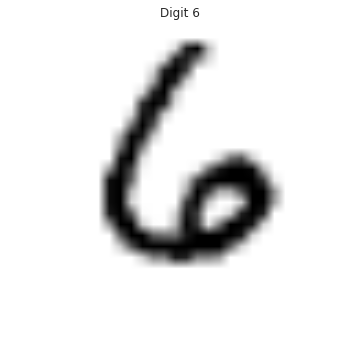

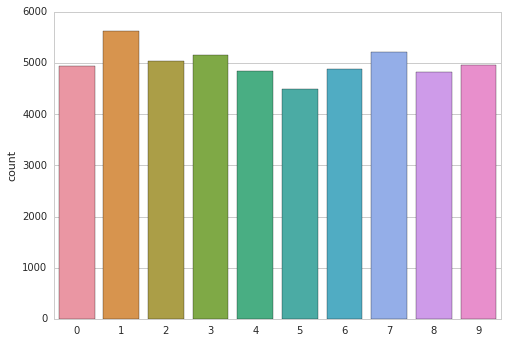


Max: 5632 Label 1
Min: 4500 Label 5
Max/Min = 1.25



In [6]:
# check data

print('original_valid_id:', original_valid_id.shape)
print('original_valid_image:', original_valid_image.shape)
print('original_valid_label:', original_valid_label.shape)

for i in range(10, 10+3):
    data_digit_recognizer.show_digit(original_valid_image[i], original_valid_label[i])
    
data_digit_recognizer.analyze_labels(original_valid_label)


In [7]:
# preprocessing
x_train = original_train_image.reshape(-1, 1, IMAGE_ROWS, IMAGE_COLS).astype('float32') / 255
y_train = np_utils.to_categorical(original_train_label, 10)

x_valid = original_valid_image.reshape(-1, 1, IMAGE_ROWS, IMAGE_COLS).astype('float32') / 255
y_valid = np_utils.to_categorical(original_valid_label, 10)

print('x_train shape: {}'.format(x_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('x_valid shape: {}'.format(x_valid.shape))
print('y_valid shape: {}'.format(y_valid.shape))

x_train shape: (10000, 1, 28, 28)
y_train shape: (10000, 10)
x_valid shape: (50000, 1, 28, 28)
y_valid shape: (50000, 10)


In [8]:
# model

import random
seed_num = 333
random.seed(seed_num)
np.random.seed(seed_num)  # for reproducibility

model = Sequential()

# Layer 1
model.add(Convolution2D(6, 5, 5,
                        border_mode='valid',
                        input_shape=(1, 28, 28)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2
model.add(Convolution2D(16, 5, 5))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Full connect
model.add(Flatten())
model.add(Dense(120))
model.add(Activation('relu'))

model.add(Dense(84))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4))

In [9]:
%%time

# Train

BATCH_SIZE = 50
# EPOCH_COUNT = 5
EPOCH_COUNT = 200

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, nb_epoch=EPOCH_COUNT,
              show_accuracy=True, verbose=1, validation_data=(x_valid, y_valid))

Train on 10000 samples, validate on 50000 samples
Epoch 1/200
10000/10000 [==============================] - 28s - loss: 1.9963 - acc: 0.3062 - val_loss: 1.4896 - val_acc: 0.6767
Epoch 2/200
10000/10000 [==============================] - 28s - loss: 1.2512 - acc: 0.6136 - val_loss: 0.7876 - val_acc: 0.8166
Epoch 3/200
10000/10000 [==============================] - 28s - loss: 0.8082 - acc: 0.7498 - val_loss: 0.5239 - val_acc: 0.8608
Epoch 4/200
10000/10000 [==============================] - 28s - loss: 0.6280 - acc: 0.8101 - val_loss: 0.4200 - val_acc: 0.8856
Epoch 5/200
10000/10000 [==============================] - 28s - loss: 0.5196 - acc: 0.8427 - val_loss: 0.3597 - val_acc: 0.8970
Epoch 6/200
10000/10000 [==============================] - 28s - loss: 0.4507 - acc: 0.8658 - val_loss: 0.3124 - val_acc: 0.9095
Epoch 7/200
10000/10000 [==============================] - 28s - loss: 0.3974 - acc: 0.8802 - val_loss: 0.2819 - val_acc: 0.9185
Epoch 8/200
10000/10000 [======================

In [9]:
history.history['loss']

[0.69913253434002398,
 0.21768185494467615,
 0.14314221126958729,
 0.10940100106410683,
 0.08630336251109838,
 0.074783223001286384,
 0.061071064709685742,
 0.050519181173294785,
 0.050460064597427842,
 0.042058662833878768,
 0.035776804881170389,
 0.033088406070601192,
 0.027222473066067322,
 0.026328338888997677,
 0.026125157769711221,
 0.023637724561267531,
 0.0189736716056359,
 0.017474394812306854,
 0.018057363234547666,
 0.01600266635607113,
 0.016704066101810897,
 0.015782263833170874,
 0.013950399073510198,
 0.012160840991709847,
 0.012587803840142442,
 0.011718603689805604,
 0.0092473113470623505,
 0.010546176252973964,
 0.0092952508668531671,
 0.0088166554978124628]

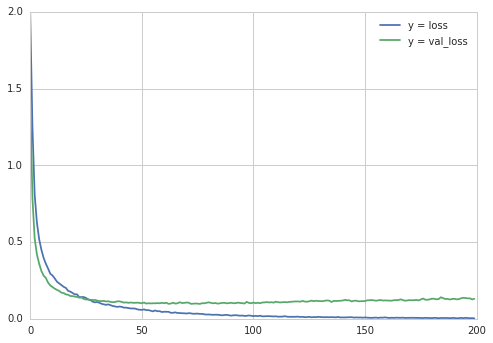

In [10]:
import matplotlib.pyplot as plt

x = np.arange(len(history.history['loss']))
plt.plot(x, history.history['loss'])
plt.plot(x, history.history['val_loss'])

plt.legend(['y = loss', 'y = val_loss'], loc='upper right')

plt.show()

In [11]:
for i in range(len(history.history['val_loss'])):
    if(history.history['val_loss'][i]==min(history.history['val_loss'])):
        print('min val_loss:{:.6f}, index:{}'.format(min(history.history['val_loss']).item(), i))

for i in range(len(history.history['loss'])):
    if(history.history['loss'][i]==min(history.history['loss'])):
        print('min loss: {:.6f}, index:{}'.format(min(history.history['loss']).item(), i))
    

min val_loss:0.096885, index:76
min loss: 0.002886, index:199


In [12]:
#save model 
def save_keras_model(model, path):
    with open(path + '.json', 'w') as f:
        f.write(model.to_json())
    model.save_weights(path+'.h5', overwrite=True)

save_keras_model( model, '6C5-MP2-16C5-MP5-120N-84N-10N-test4' )